In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import random
import matplotlib.pyplot as plt
import math
import glob
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from data_processing import get_data, get_sources_targets_short, get_source_target, get_speed_short, get_with_speed

In [2]:
class Encoder(nn.Module):
    def __init__(self,
                 input_size = 4,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers,
                           dropout = dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        """
        x: input batch data, size: [sequence len, batch size, feature size] #15 20 4
        """
        # embedded: [sequence len, batch size, embedding size]
        embedded = self.dropout(F.relu(self.linear(x))) #[100, 20, 128]
        # you can checkout https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM
        # for details of the return tensor
        # briefly speaking, output coontains the output of last layer for each time step
        # hidden and cell contains the last time step hidden and cell state of each layer
        # we only use hidden and cell as context to feed into decoder
        output, hidden = self.rnn(embedded, hidden) # hidden = [4, 20, 256]
        # hidden = [n layers * n directions, batch size, hidden size]
        # cell = [n layers * n directions, batch size, hidden size]
        # the n direction is 1 since we are not using bidirectional RNNs
        return hidden
    def init_hidden(self):
        return (torch.zeros(self.n_layers, BATCH_SIZE, self.hidden_size),
                torch.zeros(self.n_layers, BATCH_SIZE, self.hidden_size))

In [3]:
class Decoder(nn.Module):
    def __init__(self,
                 output_size = 4,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Linear(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout = dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        """
        x : input batch data, size(x): [batch size, feature size]
        notice x only has two dimensions since the input is batchs
        of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        # after this, size(x) will be [1, batch size, feature size]
        x = x.unsqueeze(0)

        # embedded = [1, batch size, embedding size]
        embedded = self.dropout(F.relu(self.embedding(x)))
            
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = ([n layers * n directions, batch size, hid dim], [n layers * n directions, batch size, hid dim])
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hidden size]
        #hidden = ([n layers, batch size, hidden size], [n layers, batch size, hidden size])
        output, hidden = self.rnn(embedded,hidden)

        # prediction = [batch size, output size]
        prediction = self.linear(output.squeeze(0))

        return prediction, hidden

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.attn = nn.Linear(self.encoder.hidden_size*2, 1)
        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, target_ordinal =1, num_target = 5,  teacher_forcing_ratio = 0.5):
        """
         x = [batch size, seq len, feature size] 20,15,11,2  
         y = [20, 15, 3, 2]
        """
        x = x.permute(2, 1, 0, 3)  #11, 15, 20, 4
        y = y.permute(2, 1, 0, 3)  #3, 15, 20, 4
        outputs = torch.zeros(y.shape).to(self.device) # 3, 15, 20, 4
        
        batch_size = x.shape[2]
        ref_size = x.shape[0]
        target_len = y.shape[1]
        
        total_h = []
        total_c = []
        for each_x in x:
            
            hidden = self.encoder(each_x, self.encoder.init_hidden()) #[4, 20, 256]*2
            total_h.append(hidden[0].unsqueeze(0))
            total_c.append(hidden[1].unsqueeze(0))
        total_hidden= (torch.cat(total_h, dim = 0), torch.cat(total_c, dim = 0))#([11,4, 20,256], [11, 4, 20, 256])
        
        for j in range(num_target) : #3
            
            # first input to decoder is last coordinates of x
            decoder_input = x[target_ordinal+j, -1, :, :] 
            hidden_h = total_hidden[0][target_ordinal+j].clone() #[4, 20, 256] 
            hidden_c = total_hidden[1][target_ordinal+j].clone()
            
            weights = []
            
            for neighbor_hidden in total_hidden[0]:  #neighbor_hidden =[4, 20, 256]
                weights.append(self.attn(torch.cat((hidden_h[0], neighbor_hidden[0]), dim = 1)))  #each weight = [ 20, 1]
            normalized_weights = F.softmax(torch.cat(weights, 1), 1) #[20,11]
                
               
            for i in range(self.decoder.n_layers):
                hidden_h[i] = torch.bmm(normalized_weights.unsqueeze(1), total_hidden[0].permute(1, 2, 0, 3)[i]).permute(1, 0, 2)
                hidden_c[i] = torch.bmm(normalized_weights.unsqueeze(1), total_hidden[1].permute(1, 2, 0, 3)[i]).permute(1, 0, 2)
                   #[20,1, 11]dot[20, 11, 256] = [20, 1, 256] =>[1, 20, 256] =>[4, 20, 256]   
            
            new_hidden = (hidden_h, hidden_c)
            
            for i in range(target_len): #15
                # run decode for one time step
                
                output, hidden = self.decoder(decoder_input, new_hidden)

                # place predictions in a tensor holding predictions for each time step
                
                outputs[j][i] = output

                # decide if we are going to use teacher forcing or not
                teacher_forcing = random.random() < teacher_forcing_ratio

                # output is the same shape as input, [batch_size, feature size]
                # so we can use output directly as input or use true lable depending on
                # teacher_forcing is true or not
                decoder_input = y[j][i] if teacher_forcing else output
        outputs = outputs.permute(2,1, 0, 3) #5, 15, 20, 4=> 20, 15, 5, 2
      
        return outputs

In [5]:
# produce dataset
class MyDataset(Dataset):
    def __init__(self,data):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        super().__init__()
        self.data = data
        

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        
        return self.data[index]
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.data)



In [6]:
path = './data'
df = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
game_data, flag_index = get_data(df)
print(game_data[0], flag_index[:5])

[53.11965 27.65268] [    0  5621 11154 12562 13750]


In [7]:
source_ordinal = 0
num_source = 11
target_ordinal = 1
num_target = 3
sources, targets = get_sources_targets_short(game_data, flag_index, 15)
s_speeds, t_speeds = get_speed_short(game_data, flag_index, 15)
# source, target = get_source_target(sources, targets, source_ordinal,num_source,target_ordinal,num_target)
source, target =get_with_speed(sources,s_speeds, source_ordinal,num_source,targets, t_speeds, target_ordinal,num_target )


In [8]:
BATCH_SIZE = 20
total = []
for i in range(len(source)):
    temp = (source[i], target[i])
    total.append(temp)
example = []
for i in range(BATCH_SIZE):
    temp = (source[i], target[i])
    example.append(temp)

In [9]:
total_data = MyDataset(total)
ex_data =MyDataset(example)
train_size = int(len(total_data) * 0.7)
val_size = int(len(total_data)*0.2)
test_size = len(total_data) - train_size - val_size
train_data,val_data, test_data =random_split(total_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
ex_loader = DataLoader(ex_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = False)


In [10]:
print(iter(train_loader).__next__()[0].shape,iter(train_loader).__next__()[1].shape )
print(iter(ex_loader).__next__()[0].shape,iter(ex_loader).__next__()[1].shape )

torch.Size([20, 15, 11, 4]) torch.Size([20, 15, 3, 4])
torch.Size([20, 15, 11, 4]) torch.Size([20, 15, 3, 4])


In [11]:
INPUT_DIM = 4
OUTPUT_DIM = 4
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Seq2Seq(enc, dec, dev).to(dev)

In [12]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x, y) in enumerate(dataloader):
        # put data into GPU
        
        x = x.to(dev)
        y = y.to(dev)
        
        # zero all param gradients
        optimizer.zero_grad()
        
        # run seq2seq to get predictions
        y_pred = model(x, y,target_ordinal, num_target, 0.5)
#         plt.plot(y_pred[:,0], y_pred[:, 1], color = 'tab:greem')

        
        # get loss and compute model trainable params gradients though backpropagation
        loss = criterion(y_pred, y)
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # add batch loss, since loss is single item tensor
        # we can get its value by loss.item()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)




In [13]:
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(dev)
            y = y.to(dev)
            
            # turn off teacher forcing
            y_pred = model(x, y, target_ordinal, num_target, 0)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)


In [14]:
N_EPOCHES = 20
best_val_loss = float('inf')
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [15]:
# load previous best model params if exists
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_11_3_speed.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")
    


successfully load previous best model parameters


In [16]:
%load_ext tensorboard
writer = SummaryWriter()

In [21]:
for epoch in range(N_EPOCHES):
    
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    end_time = time.time()
    secs = end_time - start_time
    
    print(F'Epoch: {epoch+1:02} | Time:  {secs}s')
    print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val Loss: {val_loss:.3f}')
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss,epoch)
   
   
   

    if val_loss < best_val_loss:
        os.makedirs(model_dir, exist_ok=True)
        torch.save(model.state_dict(), saved_model_path)
writer.close()

Epoch: 01 | Time:  135.30418229103088s
	Train Loss: 73.662
	 Val Loss: 78.960
Epoch: 02 | Time:  136.1543152332306s
	Train Loss: 68.162
	 Val Loss: 66.336
Epoch: 03 | Time:  135.65430569648743s
	Train Loss: 67.404
	 Val Loss: 66.515
Epoch: 04 | Time:  137.0430929660797s
	Train Loss: 66.519
	 Val Loss: 70.201
Epoch: 05 | Time:  137.04174900054932s
	Train Loss: 65.270
	 Val Loss: 69.413
Epoch: 06 | Time:  137.7270474433899s
	Train Loss: 70.734
	 Val Loss: 67.236


KeyboardInterrupt: 

In [22]:

test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} ')

| Test Loss: 71.679 


<Figure size 432x288 with 0 Axes>

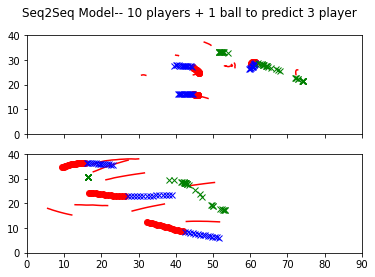

In [23]:
scenes = 2
plt.clf()
fig, axs = plt.subplots(scenes,sharex=True, sharey=True )
plt.axis([0, 90, 0, 40])
fig.suptitle('Seq2Seq Model-- 10 players + 1 ball to predict 3 player')
p, q = iter(ex_loader).__next__()  # p [20, 15, 11, 4] q [20, 15, 3, 4]
r = model(p, q, target_ordinal, num_target).detach()  #r [20, 15, 3, 4]
p_= p.permute(0, 2, 1, 3) #20, 11, 15, 4
q_= q.permute(0, 2, 1, 3) 
r_= r.permute(0, 2, 1, 3)
for j in range(scenes):
    for i in range(len(p_[j])):
        if (i >= target_ordinal and i < target_ordinal + num_target):
            axs[j].plot(p_[j][i][:, 0], p_[j][i][:, 1], 'ro', linewidth=0.5, label = "source")
          
        axs[j].plot(p_[j][i][:, 0], p_[j][i][:, 1], color = "red", label ="ref", )
    for i in range(len(q_[j])):
        axs[j].plot(q_[j][i][:, 0], q_[j][i][:, 1], "bx", linewidth = 0.2, label = "target")
        axs[j].plot(r_[j][i][:, 0], r_[j][i][:, 1], "gx", linewidth = 0.2, label = "predict")

plt.show()


In [ ]:
#!tensorboard --logdir=runs